<font size="+12"><center>
    MVPA analysis: SVM
</font></center>

Author:
Egor Ananyev

# Preparation

## Loading packages

In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [2]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
mne.set_log_level('warning')  # less verbose output

## Setting parameters

In [4]:
cur_subj = 1
numof_runs = 7  # TEMP; is 7 for subj 01

## Loading evoked data

In [23]:
# data_path = os.path.expanduser("C:\\Users\\egora\\Downloads\\meg\\")
data_path = os.path.expanduser('E:\\meg\\')

cur_subj_str = str(cur_subj).zfill(2)

for cur_run in range(numof_runs):
    cur_run_str = str(cur_run+1).zfill(2)
    fname = os.path.join(data_path,
                             'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg\\sub-' + \
                             cur_subj_str + '_ses-meg_experimental_run-' + cur_run_str + '_proc-sss_epo.fif')
    print(fname)
    epochs_run = mne.read_epochs(fname)
    # example append: https://www.programcreek.com/python/example/92634/mne.Epochs
    epochs_run = epochs_run.pick_types(meg=True)
    epochs_run_df = epochs_run.to_data_frame()
    # Normalizing the signal by the baseline:
    epochs_run_std = epochs_run_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1])
    epochs_run_std = epochs_run_std.loc[pd.IndexSlice[:, :, -100:-1], :].groupby(['condition', 'epoch']).std()
    epochs_run_norm = epochs_run_df / epochs_run_std
    if cur_run == 0:
        epochs_df = epochs_run_norm
    else: 
        epochs_df = epochs_df.append(epochs_run_norm)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-01_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-02_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-03_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-04_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-05_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-06_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-07_proc-sss_epo.fif


In [24]:
np.shape(epochs_df)

(706608, 306)

The path to store MVPA-related data and visualization.

In [12]:
mvpa_path = os.path.join(data_path, 'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg-mvpa\\')
mvpa_fname = os.path.join(mvpa_path, 'sub-' + cur_subj_str)
print(mvpa_fname)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg-mvpa\sub-01


# Support Vector Machines

## SVM routine

In [13]:
def run_svm(X_, y_, kernel_='sigmoid', n_splits=10, track=True):
    acc_list = []
    ss = ShuffleSplit(n_splits=n_splits, test_size=0.2)
    for train_index, test_index in ss.split(X_):
        X_train = X_[train_index]
        y_train = y_[train_index]
        X_test = X_[test_index]
        y_test = y_[test_index]
        clf = svm.SVC(C=0.1, kernel=kernel_, gamma=0.001, cache_size=2000).fit(X_train, y_train)
    #     clf = svm.SVR(cache_size=2000).fit(X_train, y_train)  # won't work with accuracy_score
    #     scores = cross_val_score(clf, X_train, y_train, cv=4)
    #     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        y_pred = clf.predict(X_test)
    #     print(classification_report(y_test, y_pred))
        this_acc = accuracy_score(y_test, y_pred)
        acc_list.append(this_acc)
    #     print(accuracy_score(y_test, y_pred))
    if track:
        print('{0:.2f}'.format(np.mean(acc_list)), end=' ')
    return np.mean(acc_list), np.std(acc_list)

## Iterating through _t_

### Indexing logic

In [59]:
t = -99
epochs_df_sorted = epochs_df.copy()

In [60]:
epochs_df_sorted.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1], inplace=True)

Note that there might be several epochs with the same index per time point. This is of no essence.

In [61]:
epochs_df_sorted[epochs_df_sorted.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t:t+2], :].head(10)

channel                         MEG0111   MEG0112   MEG0113   MEG0121  \
condition          epoch time                                           
right/dur1/cont017 11    -99   0.092519  0.527134  0.001782 -0.579203   
                         -98   0.412762 -0.243170  0.765381 -0.444475   
                         -97  -0.721618 -1.075754  0.717821 -1.070619   
                   16    -99   0.048492  0.660727 -0.231832  0.467660   
                         -99   1.082344 -0.020703  2.151818 -0.653911   
                         -98  -0.960621  0.540175 -0.746308 -0.789565   
                         -98   0.819679  1.064582  1.323924 -0.720654   
                         -97  -0.810616 -0.906892 -0.853572 -0.302699   
                         -97   0.787754  1.956866  0.946988  0.152848   
                   22    -99  -0.354338  0.749424 -0.623016 -0.455043   

channel                         MEG0122   MEG0123   MEG0131   MEG0132  \
condition          epoch time                                           
right/dur1/cont017 11    -99   0.987419  0.480592 -0.375459  0.757054   
                         -98   1.229218  1.506282 -0.665502  1.685719   
                         -97   0.893349  1.092109 -1.549719  2.012225   
                   16    -99  -1.045358 -0.734786 -0.247667 -0.688673   
                         -99   1.265922 -1.256264 -0.423758  2.088990   
                         -98  -1.905695  0.692091 -0.584949 -0.669143   
                         -98   0.589183  0.599054  0.455748  1.465534   
                         -97  -1.153240  0.040086 -0.343781 -1.950733   
                         -97  -0.647129  1.065710  0.655989  0.348697   
                   22    -99  -0.204499 -0.072587 -0.299003 -1.031946   

channel                         MEG0133   MEG0141  ...   MEG2613   MEG2621  \
condition          epoch time                      ...                       
right/dur1/cont017 11    -99   0.978742  0.352639  ...  1.016896  1.227602   
                         -98  -0.439807  0.244450  ...  0.677301 -0.213522   
                         -97  -0.684367 -1.258963  ...  0.060038 -1.439652   
                   16    -99  -1.363715 -0.074459  ...  1.546608  1.268870   
                         -99   0.923060  0.843821  ... -0.833545 -0.320841   
                         -98  -0.151066 -0.811708  ...  0.786531  0.876208   
                         -98   0.480969  1.038651  ... -1.037045 -1.636828   
                         -97  -0.056094 -0.955016  ...  0.374566  0.661385   
                         -97   0.628523  1.409902  ... -1.647150 -1.049820   
                   22    -99   0.731453 -0.349746  ...  0.043132  0.346596   

channel                         MEG2622   MEG2623   MEG2631   MEG2632  \
condition          epoch time                                           
right/dur1/cont017 11    -99   0.106611 -0.296267  1.278963  0.055740   
                         -98  -0.310566 -0.582542 -0.060151 -0.301441   
                         -97  -1.497404 -1.670321 -0.763688 -1.101015   
                   16    -99   0.802918  1.730506  1.102430  1.296391   
                         -99  -1.280975  0.657511 -0.009122 -0.760565   
                         -98   0.683992  1.713315  0.699155  1.116865   
                         -98  -0.145597 -0.550218 -1.696699 -0.493626   
                         -97   0.670397  0.960070  0.466338  0.995221   
                         -97  -0.096711 -0.472613 -1.033206 -1.014536   
                   22    -99   1.548875 -0.058564 -0.245852  1.443973   

channel                         MEG2633   MEG2641   MEG2642   MEG2643  
condition          epoch time                                          
right/dur1/cont017 11    -99  -0.528191  1.797430 -0.472305 -0.643920  
                         -98  -0.112234  1.150265 -1.601166  0.358227  
                         -97  -1.807018  0.767591 -1.539150 -0.414015  
                   16    -99   1.839522  0.455736  2.649090  1.277000  


### Function

In [72]:
def iter_times(all_times_, epochs_subset_df_, multi_t, kernel='sigmoid', n_splits=10, track=True):  #, validate=False):
    acc_mean = []
    acc_sd = []
    counter = 0
    print('[', end=' ')
    for t in all_times_:
        if (counter == int(len(all_times)/10)):
            print('||', end=' ')
            counter = 0
        counter += 1
        X_right = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t:t+multi_t-1], :]
        X_left = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t:t+multi_t-1], :]
        X = np.concatenate((X_right, X_left))
        y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))
        acc_this_mean, acc_this_sd = run_svm(X, y, kernel_=kernel, n_splits=n_splits, track=track)
        acc_mean.append(acc_this_mean)
        acc_sd.append(acc_this_sd)
    print(']')
    return acc_mean, acc_sd

# Training across 3 timepoints

In [25]:
multi_t = 3  # training across this many t's
all_times = np.round(epochs_run.times * 1000).astype(int)[1::multi_t]  # taking every multi_t's t for indexing
print(all_times)
print(np.shape(all_times))

[-99 -96 -93 -90 -87 -84 -81 -78 -75 -72 -69 -66 -63 -60 -57 -54 -51 -48
 -45 -42 -39 -36 -33 -30 -27 -24 -21 -18 -15 -12  -9  -6  -3   0   3   6
   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60
  63  66  69  72  75  78  81  84  87  90  93  96  99 102 105 108 111 114
 117 120 123 126 129 132 135 138 141 144 147 150 153 156 159 162 165 168
 171 174 177 180 183 186 189 192 195 198 201 204 207 210 213 216 219 222
 225 228 231 234 237 240 243 246 249 252 255 258 261 264 267 270 273 276
 279 282 285 288 291 294 297 300 303 306 309 312 315 318 321 324 327 330
 333 336 339 342 345 348 351 354 357 360 363 366 369 372 375 378 381 384
 387 390 393 396 399 402 405 408 411 414 417 420 423 426 429 432 435 438
 441 444 447 450 453 456 459 462 465 468 471 474 477 480 483 486 489 492
 495 498 501 504 507 510 513 516 519 522 525 528 531 534 537 540 543 546
 549 552 555 558 561 564 567 570 573 576 579 582 585 588 591 594 597 600]
(234,)


In [64]:
acc = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
acc_sd = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
epochs_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1], inplace=True)
cur_acc_mean, cur_acc_sd = iter_times(all_times, epochs_df, multi_t, track=True, n_splits=25)  #, validate=False)
acc.loc[0, :] = cur_acc_mean
acc_sd.loc[0, :] = cur_acc_sd

[ 0.53 0.52 0.52 0.54 0.53 0.53 0.51 0.52 0.49 0.49 0.50 0.50 0.50 0.51 0.53 0.52 0.51 0.49 0.50 0.50 0.51 0.49 0.49 || 0.49 0.52 0.52 0.52 0.49 0.49 0.49 0.50 0.53 0.51 0.53 0.52 0.52 0.53 0.54 0.54 0.52 0.52 0.52 0.52 0.50 0.52 0.51 || 0.50 0.52 0.53 0.55 0.57 0.57 0.55 0.54 0.54 0.54 0.55 0.54 0.56 0.55 0.54 0.58 0.58 0.58 0.56 0.53 0.54 0.54 0.56 || 0.54 0.55 0.54 0.55 0.54 0.55 0.55 0.55 0.56 0.57 0.56 0.56 0.56 0.53 0.53 0.54 0.53 0.51 0.52 0.50 0.50 0.49 0.50 || 0.50 0.53 0.52 0.53 0.53 0.53 0.53 0.53 0.52 0.52 0.54 0.54 0.54 0.52 0.51 0.52 0.53 0.54 0.53 0.53 0.51 0.53 0.51 || 0.53 0.54 0.55 0.52 0.54 0.55 0.51 0.51 0.53 0.52 0.52 0.52 0.50 0.52 0.52 0.54 0.54 0.53 0.54 0.56 0.56 0.54 0.55 || 0.52 0.52 0.51 0.51 0.51 0.52 0.49 0.50 0.49 0.52 0.51 0.51 0.52 0.50 0.51 0.52 0.52 0.50 0.51 0.52 0.50 0.52 0.52 || 0.52 0.52 0.51 0.51 0.51 0.51 0.51 0.51 0.50 0.51 0.51 0.51 0.50 0.51 0.51 0.51 0.50 0.51 0.51 0.50 0.51 0.51 0.50 || 0.51 0.50 0.50 0.49 0.50 0.51 0.49 0.50 0.50 0.50 0.50

In [65]:
acc.to_csv(mvpa_fname + '_acc_multi-t-3.csv')

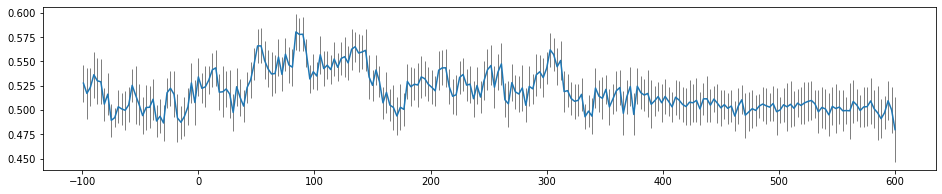

In [66]:
%matplotlib inline
plt.figure(figsize=(16, 3))
# plt.plot(all_times, np.array(acc.T));
plt.errorbar(all_times, np.array(acc.T), yerr=acc_sd.to_numpy().flatten(), ecolor='gray', elinewidth=1)
plt.savefig(mvpa_fname + '_sigmoid_sd' + '.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

# Training across 6 timepoints

In [68]:
multi_t = 6  # training across this many t's
all_times = np.round(epochs_run.times * 1000).astype(int)[0::multi_t]  # taking every multi_t's t for indexing
print(all_times)
print(np.shape(all_times))

[-100  -94  -88  -82  -76  -70  -64  -58  -52  -46  -40  -34  -28  -22
  -16  -10   -4    2    8   14   20   26   32   38   44   50   56   62
   68   74   80   86   92   98  104  110  116  122  128  134  140  146
  152  158  164  170  176  182  188  194  200  206  212  218  224  230
  236  242  248  254  260  266  272  278  284  290  296  302  308  314
  320  326  332  338  344  350  356  362  368  374  380  386  392  398
  404  410  416  422  428  434  440  446  452  458  464  470  476  482
  488  494  500  506  512  518  524  530  536  542  548  554  560  566
  572  578  584  590  596]
(117,)


In [73]:
acc = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
acc_sd = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
epochs_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1], inplace=True)
cur_acc_mean, cur_acc_sd = iter_times(all_times, epochs_df, multi_t, track=True, n_splits=25)  #, validate=False)
acc.loc[0, :] = cur_acc_mean
acc_sd.loc[0, :] = cur_acc_sd

[ 0.53 0.54 0.55 0.53 0.51 0.52 0.52 0.54 0.53 0.53 0.53 || 0.50 0.54 0.53 0.52 0.53 0.54 0.55 0.56 0.54 0.54 0.53 || 0.53 0.53 0.56 0.57 0.57 0.55 0.56 0.56 0.57 0.60 0.57 || 0.56 0.57 0.56 0.56 0.56 0.57 0.57 0.57 0.55 0.55 0.53 || 0.52 0.52 0.53 0.54 0.53 0.55 0.53 0.55 0.54 0.54 0.55 || 0.54 0.52 0.51 0.53 0.52 0.52 0.51 0.51 0.50 0.50 0.52 || 0.51 0.53 0.52 0.51 0.50 0.51 0.51 0.50 0.50 0.50 0.50 || 0.51 0.51 0.50 0.51 0.50 0.51 0.51 0.51 0.51 0.51 0.50 || 0.50 0.51 0.51 0.51 0.51 0.50 0.50 0.50 0.49 0.50 0.51 || 0.51 0.51 0.51 0.50 0.51 0.51 0.51 0.51 0.50 0.51 0.51 || 0.50 0.51 0.50 0.50 0.50 0.49 0.50 ]


In [74]:
acc.to_csv(mvpa_fname + '_acc_multi-t-6.csv')

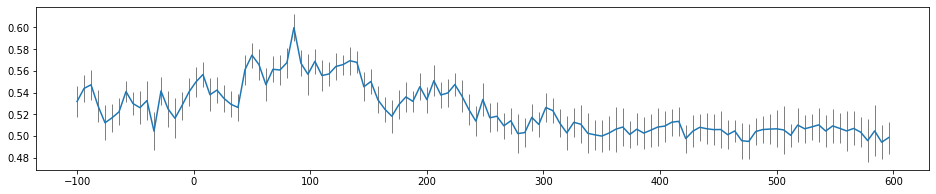

In [75]:
%matplotlib inline
plt.figure(figsize=(16, 3))
# plt.plot(all_times, np.array(acc.T));
plt.errorbar(all_times, np.array(acc.T), yerr=acc_sd.to_numpy().flatten(), ecolor='gray', elinewidth=1)
plt.savefig(mvpa_fname + '_sigmoid_sd' + '.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

# Training across 10 timepoints

In [76]:
multi_t = 10  # training across this many t's
all_times = np.round(epochs_run.times * 1000).astype(int)[0::multi_t]  # taking every multi_t's t for indexing
print(all_times)
print(np.shape(all_times))

[-100  -90  -80  -70  -60  -50  -40  -30  -20  -10    0   10   20   30
   40   50   60   70   80   90  100  110  120  130  140  150  160  170
  180  190  200  210  220  230  240  250  260  270  280  290  300  310
  320  330  340  350  360  370  380  390  400  410  420  430  440  450
  460  470  480  490  500  510  520  530  540  550  560  570  580  590
  600]
(71,)


In [ ]:
acc = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
acc_sd = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
epochs_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1], inplace=True)
cur_acc_mean, cur_acc_sd = iter_times(all_times, epochs_df, multi_t, track=True, n_splits=25)  #, validate=False)
acc.loc[0, :] = cur_acc_mean
acc_sd.loc[0, :] = cur_acc_sd

[ 0.54 0.55 0.53 0.53 0.54 0.53 0.52 || 0.53 0.53 0.53 0.55 0.55 0.55 0.53 || 0.55 0.57 0.57 0.55 0.59 0.57 0.56 || 0.56 0.57 0.57 0.57 0.55 0.53 0.53 || 0.53 0.53 0.53 0.54 0.52 0.51 0.51 || 0.51 0.51 0.50 0.50 0.51 0.52 0.51 || 0.51 0.51 0.50 0.50 0.51 0.50 0.50 || 0.51 0.51 0.51 0.51 0.51 0.51 0.51 || 0.50 0.50 0.51 0.50 0.51 

In [ ]:
acc.to_csv(mvpa_fname + '_acc_multi-t-10.csv')

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 3))
# plt.plot(all_times, np.array(acc.T));
plt.errorbar(all_times, np.array(acc.T), yerr=acc_sd.to_numpy().flatten(), ecolor='gray', elinewidth=1)
plt.savefig(mvpa_fname + '_sigmoid_sd' + '.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)